<a href="https://www.kaggle.com/code/lorresprz/stellar-classification-ann-cnn-v-xgbclassifier?scriptVersionId=145307620" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Stellar classification: DL (ANN/CNN) vs ML (XGBClassifier, RandomForestClassifier)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/stellar-classification-dataset-sdss17/star_classification.csv


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

#DL import
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Reshape, Flatten, Dropout, Conv1D
from tensorflow.keras.models import Sequential

#ML import
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# EDA

The objective of this classification is to determine whether an object is a star, a galaxy or a quasar (the target column is 'class' with 3 values: QSO, GALAXY, STAR), based on a set of 17 observations.  The meaning of each column in the dataset was explained in the 'Data Card' section, but included here for clarity (and self-sufficiency):

- 1. obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
- 2. alpha = Right Ascension angle (at J2000 epoch)
- 3. delta = Declination angle (at J2000 epoch)
- 4. u = Ultraviolet filter in the photometric system
- 5. g = Green filter in the photometric system
- 6. r = Red filter in the photometric system
- 7. i = Near Infrared filter in the photometric system
- 8. z = Infrared filter in the photometric system
- 9. run_ID = Run Number used to identify the specific scan
- 10. rereun_ID = Rerun Number to specify how the image was processed
- 11. cam_col = Camera column to identify the scanline within the run
- 12. field_ID = Field number to identify each field
- 13. spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the same output class)
- 14. class = object class (galaxy, star or quasar object): This is the target column.
- 15. redshift = redshift value based on the increase in wavelength
- 16. plate = plate ID, identifies each plate in SDSS
- 17. MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
- 18. fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation


In [5]:
df = pd.read_csv('/kaggle/input/stellar-classification-dataset-sdss17/star_classification.csv')
df.sample(5)

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
52952,1.237668e+18,146.120611,19.821515,23.63225,22.99951,22.17736,21.35038,20.86033,5138,301,3,41,1.078619e+19,GALAXY,0.717610,9580,57865,259
26569,1.237656e+18,357.255709,14.903996,24.51894,22.28436,20.53048,19.53502,19.14187,2566,301,4,291,6.918852e+18,GALAXY,0.493534,6145,56266,717
62418,1.237657e+18,32.722063,-0.534238,26.05325,21.24480,19.56481,18.70649,18.34603,2700,301,2,84,1.696805e+18,GALAXY,0.458015,1507,53763,268
14244,1.237658e+18,139.829822,46.528878,21.82575,19.85994,18.39118,17.87940,17.48631,2831,301,1,16,9.379637e+17,GALAXY,0.211648,833,52314,324
6778,1.237664e+18,128.992065,24.802511,22.16128,20.39846,18.67170,18.03179,17.63754,4335,301,3,123,2.170909e+18,GALAXY,0.308147,1928,53327,634


In [6]:
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


Text(0.5, 1.0, 'Number of instances for each class of stellar objects')

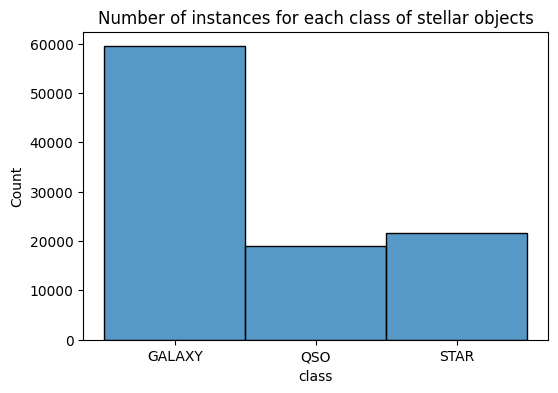

In [7]:
plt.figure(figsize = (6,4))
sns.histplot(data = df, x = 'class')
plt.title('Number of instances for each class of stellar objects')

<Axes: xlabel='alpha', ylabel='Density'>

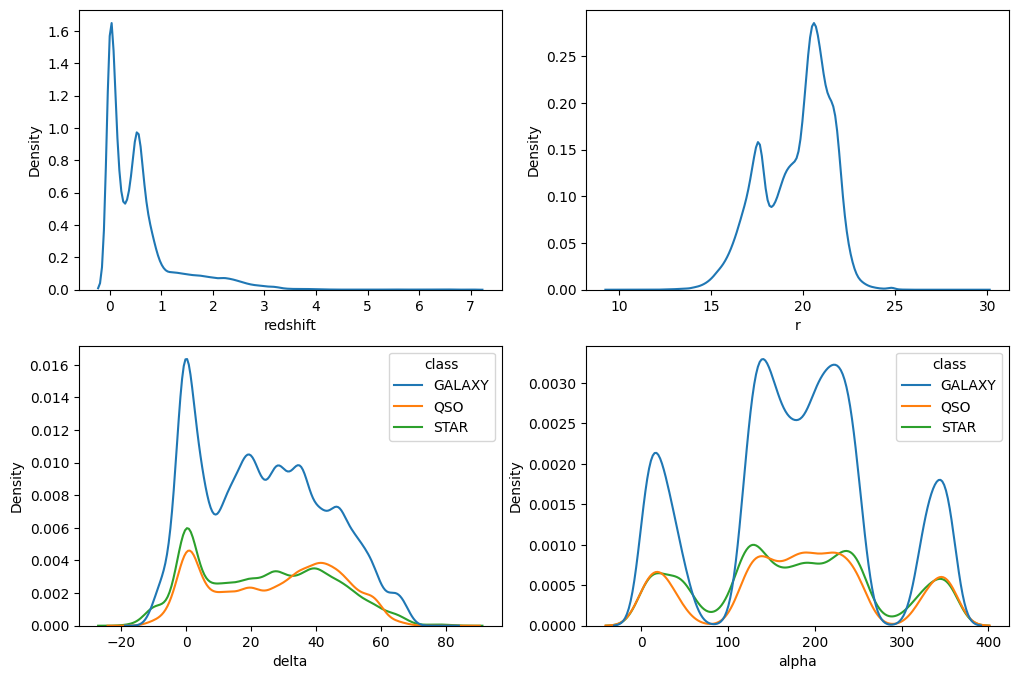

In [8]:
fig, ax = plt.subplots(2,2, figsize = (12,8))
sns.kdeplot(data = df, x = 'redshift', ax = ax[0,0])
sns.kdeplot(data = df, x = 'r', ax = ax[0,1])
sns.kdeplot(data = df, x = 'delta', hue = 'class', ax = ax[1,0])
sns.kdeplot(data = df, x = 'alpha', hue = 'class', ax = ax[1,1])


In [9]:
#Encode the 'class' target in numeric format
LE = LabelEncoder()
df['class'] = LE.fit_transform(df['class'])

<Axes: >

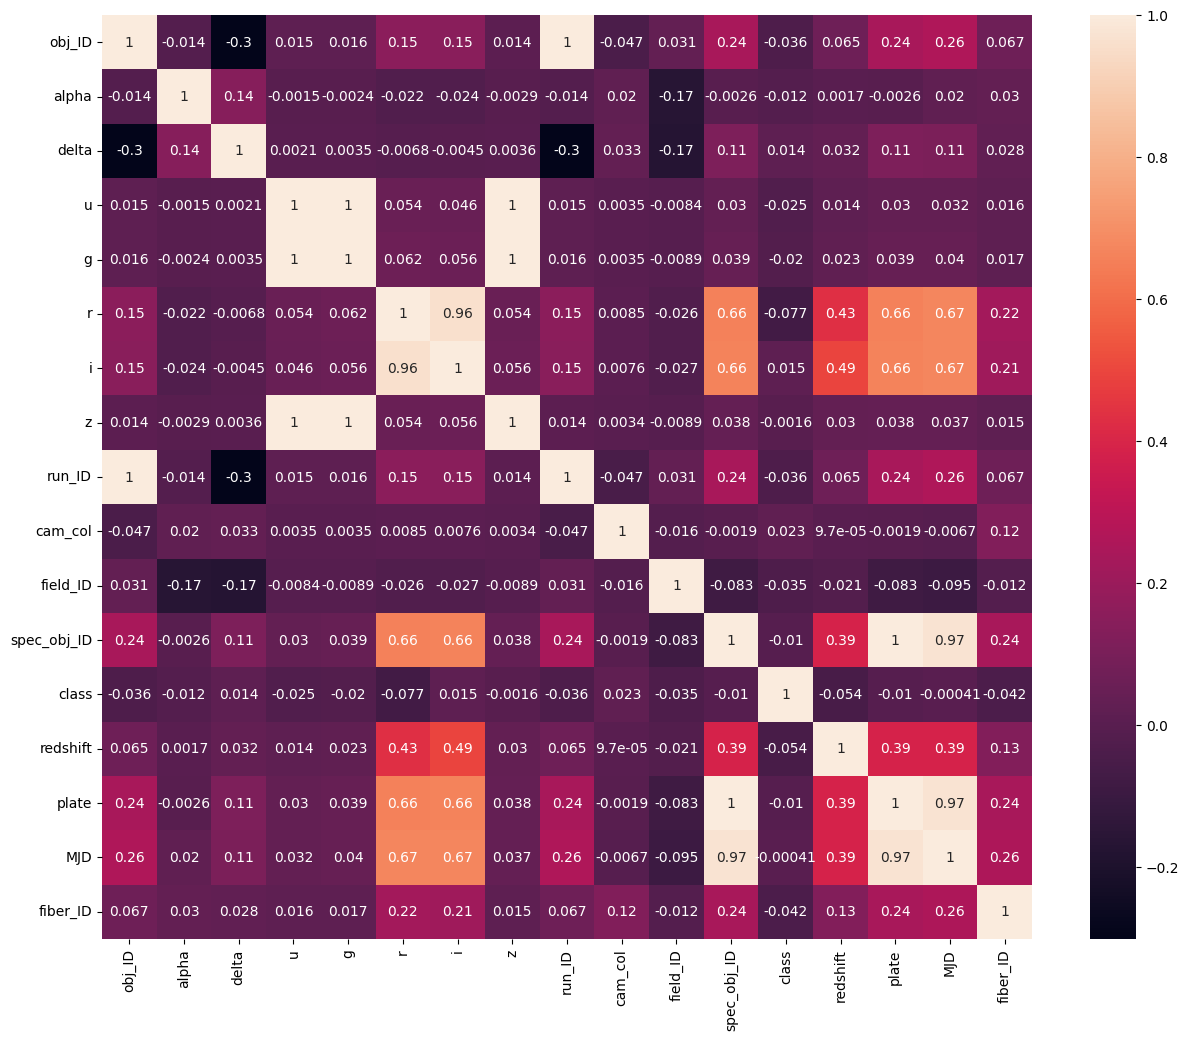

In [10]:
plt.figure(figsize = (15,12))
sns.heatmap(df.drop(['rerun_ID'],axis = 1).corr(),annot = True)

# Overview of ML methods: XGBClassifier, RandomForestClassifier, etc.

This section (and only this section) exploring various ML methods is based on the following notebook:
https://www.kaggle.com/code/geromeandrewducduc/stellar-entity-classification

Based on the results from the above notebook (section 'Feature Importance'), I used a set of reduced features comprised only of 'u, g, i, r, z, redshift' to form the basis for the classification task. Also, no oversampling was performed (despite the class imbalance). The obtained results show that the various ML methods are able to classify the target reasonably well. 

In [11]:
Xr = df[['u', 'g', 'i', 'z', 'r', 'redshift']]
yr = df['class']

Xr = np.array(Xr)
yr = np.array(yr)

xr_train, xr_test, yr_train, yr_test = train_test_split(Xr, yr, test_size = 0.2, random_state = 210)
xr_train.shape, xr_test.shape, yr_train.shape, yr_test.shape

((80000, 6), (20000, 6), (80000,), (20000,))

In [12]:
classifiers = [
    LogisticRegression(),
    SVC(),
    RandomForestClassifier(),
    KNeighborsClassifier(),
    GaussianNB(),
    DecisionTreeClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    ExtraTreesClassifier(),
    BaggingClassifier(),
    MLPClassifier(),
    XGBClassifier()
]

In [13]:
best_accuracy = 0.0
acc_list = []
classifier_list = []

for classifier in classifiers:
    pipeline = make_pipeline(StandardScaler(), classifier)
    pipeline.fit(xr_train, yr_train)
    
    yr_pred = pipeline.predict(xr_test)
    
    accuracy = accuracy_score(yr_test, yr_pred)
    acc_list.append(accuracy)
    classifier_list.append(classifier.__class__.__name__)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = classifier.__class__.__name__
    
d = {'Model': classifier_list, 'Accuracy': acc_list}
cl_df = pd.DataFrame(d, index = None)
cl_df = cl_df.set_index('Model')    


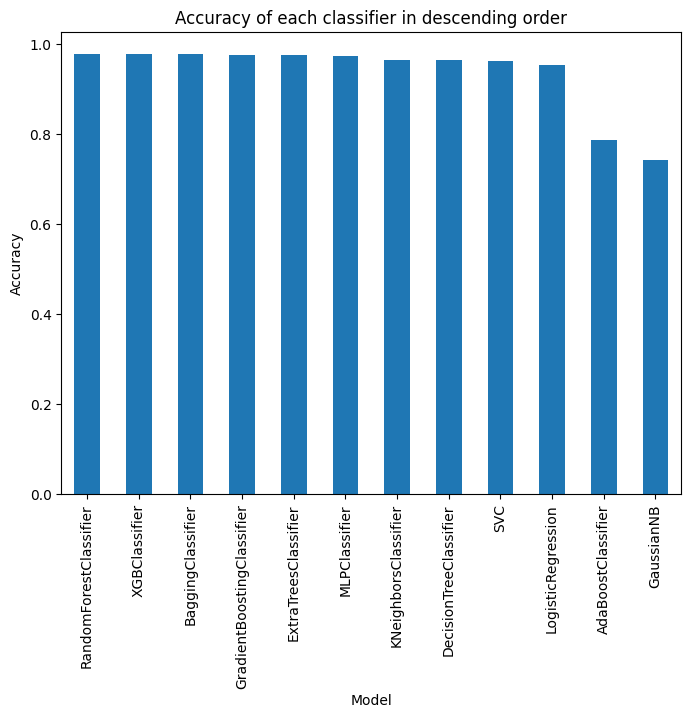

In [14]:
plt.figure(figsize = (8,6));
cl_df['Accuracy'].sort_values(ascending = False).plot(kind = 'bar')
plt.ylabel('Accuracy');
plt.title('Accuracy of each classifier in descending order');

In [15]:
cl_df

,Accuracy
Model,
LogisticRegression,0.95480
SVC,0.96270
RandomForestClassifier,0.97880
KNeighborsClassifier,0.96605
GaussianNB,0.74295
DecisionTreeClassifier,0.96550
AdaBoostClassifier,0.78635
GradientBoostingClassifier,0.97590
ExtraTreesClassifier,0.97515


# RandomForestClassifier: Tuning for best model

In [16]:
#Tuning the best RandomForestClassifier model 
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier())

param_grid = {
    'randomforestclassifier__n_estimators': [50, 100, 200],
    'randomforestclassifier__max_depth': [None, 10, 20],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(xr_train, yr_train)

best_params = grid_search.best_params_

print(best_params)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


{'randomforestclassifier__max_depth': None, 'randomforestclassifier__n_estimators': 200}


In [17]:
#Best model after tuning
model = RandomForestClassifier(n_estimators=200, max_depth=None)
model.fit(xr_train, yr_train)

RandomForestClassifier(n_estimators=200)

In [18]:
preds = model.predict(xr_test)

<Figure size 600x600 with 0 Axes>

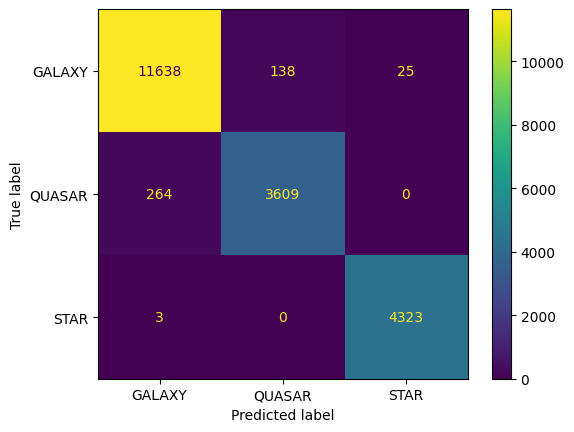

In [19]:
plt.figure(figsize = (6,6))
ConfusionMatrixDisplay.from_predictions(yr_test, preds, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

In [20]:
rf_acc = accuracy_score(yr_test, preds)
rf_acc

0.9785

# XGBClassifier: Tuning for best model

In [21]:
parameters = {
    'max_depth': range (5, 10, 20),
    'n_estimators': range(50, 100, 200),
    'learning_rate': [0.1, 0.01, 0.05]
}

#pipeline_2 = make_pipeline(StandardScaler(), XGBClassifier())

grid_search_2 = GridSearchCV(
    XGBClassifier(),
    param_grid=parameters,
    cv=5, n_jobs=-1,
    verbose=True
)

grid_search_2.fit(xr_train, yr_train)

best_params_2 = grid_search_2.best_params_
print(best_params_2)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


In [22]:
#Best model after tuning
model_2 = XGBClassifier(n_estimators=50, max_depth=5, learning_rate = 0.1)
model_2.fit(xr_train, yr_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [23]:
preds_2 = model_2.predict(xr_test)

<Figure size 600x600 with 0 Axes>

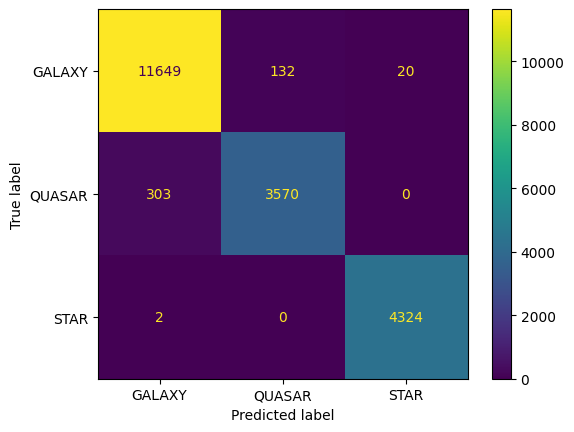

In [24]:
plt.figure(figsize = (6,6))
ConfusionMatrixDisplay.from_predictions(yr_test, preds_2, 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

In [25]:
xgb_acc = accuracy_score(yr_test, preds_2)
xgb_acc

0.97715

# Classification with ANN

We need to re-encode the 'class' target in a format usable by the ANN/CNN built for classification task.

The encoding is as follows:

    'GALAXY' -> [1,0,0] -> 0,  'STAR' -> [0,0,1] -> 2,  'QSO' -> [0,1,0] -> 1

In [26]:
from keras.utils.np_utils import to_categorical
l_encode = LabelEncoder()
l_encode.fit(yr)
Yr = l_encode.transform(yr)
Yr = to_categorical(Yr)

In [27]:
xr_train, xr_test, yr_train, yr_test = train_test_split(Xr, Yr, test_size = 0.2, random_state = 210)
xr_train.shape, xr_test.shape, yr_train.shape, yr_test.shape

((80000, 6), (20000, 6), (80000, 3), (20000, 3))

In [28]:
model_3 = Sequential([
        Dense(64, input_dim = xr_train.shape[1], activation = 'relu'),
        Dense(32, activation="relu"),
        Dense(15, activation="relu"),
        Dense(3, activation = 'softmax'),
    ])

model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
              
model_3.fit(xr_train, yr_train, validation_data=(xr_test, yr_test), epochs = 40, verbose=0)

<Axes: >

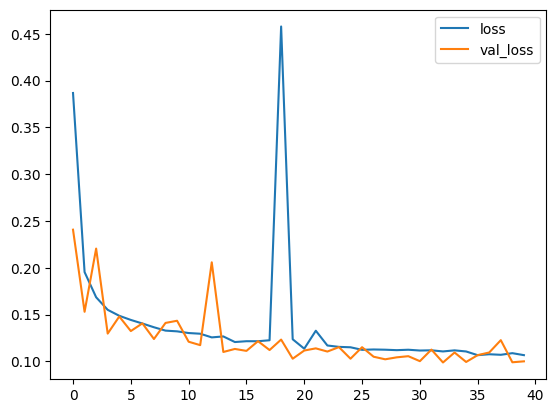

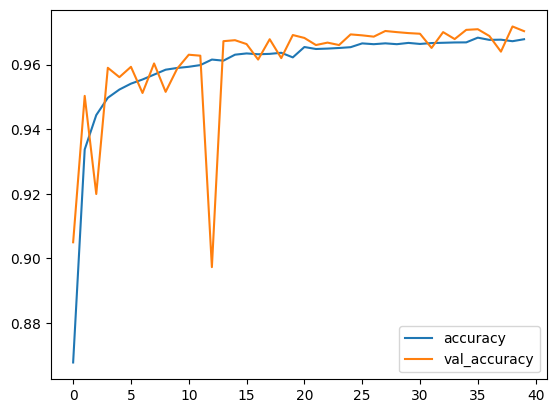

In [29]:
model_loss_acc = pd.DataFrame(model_3.history.history)
model_loss_acc[['loss', 'val_loss']].plot()
model_loss_acc[['accuracy', 'val_accuracy']].plot()

625/625 [==============================] - 1s 2ms/step


<Figure size 600x600 with 0 Axes>

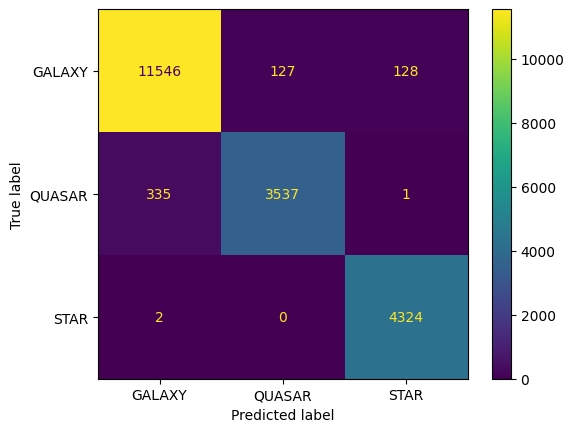

In [30]:
preds_3 = np.round(model_3.predict(xr_test))
#confusion_matrix(preds2.argmax(axis = 1), yr_test.argmax(axis = 1))

plt.figure(figsize = (6,6))
ConfusionMatrixDisplay.from_predictions(yr_test.argmax(axis = 1), preds_3.argmax(axis = 1), 
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

In [31]:
ann_acc = accuracy_score(yr_test.argmax(axis = 1), preds_3.argmax(axis =1))
ann_acc 

0.97035

# Classification with CNN

In [32]:
model_4 = Sequential(
    [Reshape((1, xr_train.shape[1],1)),
     Conv1D(filters=10, kernel_size=2, activation='relu', 
            input_shape = (1,xr_train.shape[1],1)),
     Conv1D(filters=10, kernel_size=2, activation='relu'),
     Flatten(),
     Dense(3, activation = 'softmax')
                     ])

model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
              
model_4.fit(xr_train, yr_train, validation_data=(xr_test, yr_test), epochs = 40, verbose=0)

<Axes: >

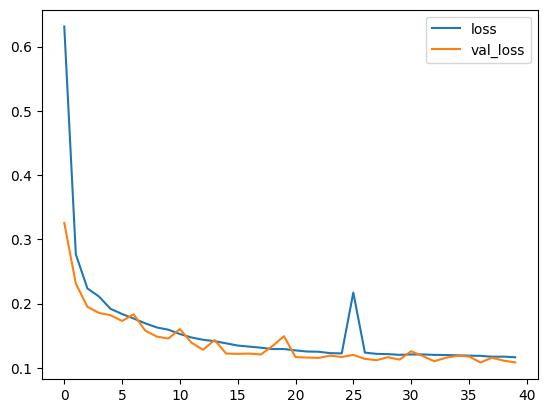

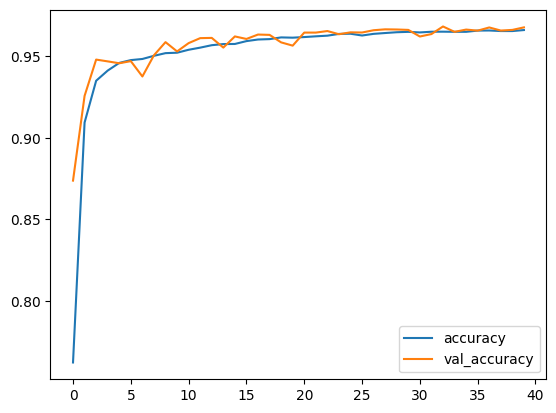

In [33]:
model4_loss_acc = pd.DataFrame(model_4.history.history)
model4_loss_acc[['loss', 'val_loss']].plot()
model4_loss_acc[['accuracy', 'val_accuracy']].plot()

625/625 [==============================] - 2s 2ms/step


<Figure size 600x600 with 0 Axes>

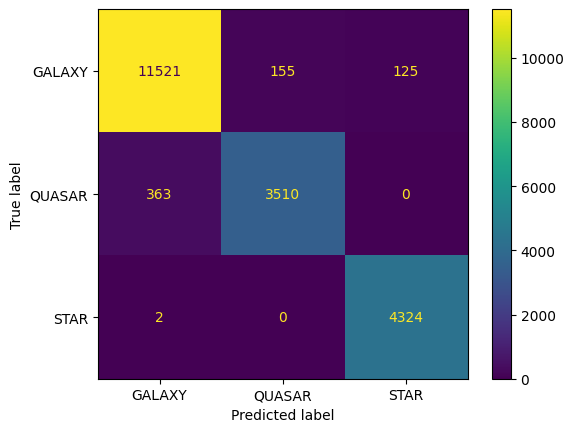

In [34]:
preds_4 = np.round(model_4.predict(xr_test))

plt.figure(figsize = (6,6))
ConfusionMatrixDisplay.from_predictions(yr_test.argmax(axis = 1),preds_4.argmax(axis = 1),
                                        display_labels = ['GALAXY', 'QUASAR', 'STAR'])

In [35]:
cnn_acc = accuracy_score(yr_test.argmax(axis = 1), preds_4.argmax(axis =1))
cnn_acc

0.96775

# DL vs ML

In [36]:
dc = {'Methods': ['RandomForestClassifier', 'XGBClassifier', 'ANN', 'CNN'], 'Accuracy': [rf_acc, xgb_acc, ann_acc, cnn_acc]}
dcf = pd.DataFrame(data=dc)
dcf = dcf.set_index('Methods')

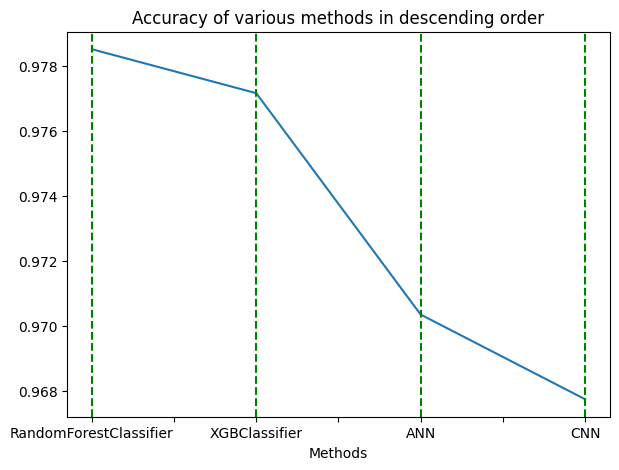

In [37]:
f, ax = plt.subplots(figsize = (7,5))
dcf['Accuracy'].sort_values(ascending = False).plot(ax = ax)
ax.axvline("CNN", color="green", linestyle="dashed")
ax.axvline("ANN", color="green", linestyle="dashed")
ax.axvline("XGBClassifier", color="green", linestyle="dashed")
ax.axvline("RandomForestClassifier", color="green", linestyle="dashed")
plt.title('Accuracy of various methods in descending order');